In [ ]:
import os, os.path as osp
from glob import glob
from natsort import os_sorted
from tqdm import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import seaborn as sns
import random

In [ ]:
# Input folder data
input_dir = 'SSC'

# split train folder into train and validation
split_train = 0.8

# Parameter for data segmentation
frame_len = 480  #จำนวน frame ต่อ 1 ชุดข้อมูล  2940 // ใช้ 100
hop_len = 1 # ระยะเหลื่อมระหว่าง frame 2940 // ใช้ 100 // เลือก 1 เพราะทำการ resample Data แล้วข้อมูลปนกัน ไม่ไม่ความต่อเนื่องแล้ว จึงเลือก 1

'''  Example
    --------
frame_len = 3
hop_len = 2

x = np.array([
    [0, 1, 2],
    [10, 11, 12],
    [20, 21, 22],
    [30, 31, 32],
    [40, 41, 42],
    [50, 51, 52],
    [60, 61, 62],
    [70, 71, 72]
])

📌 เฟรมที่ 1:
[[ 0  1  2]
 [10 11 12] 
 [20 21 22]]

📌 เฟรมที่ 2:
[[20 21 22]
 [30 31 32]
 [40 41 42]]

📌 เฟรมที่ 3:
[[40 41 42]
 [50 51 52]
 [60 61 62]]
'''


In [ ]:
train_dir = input_dir + '/train'
test_dir = input_dir + '/test'
df_paths = glob(osp.join(train_dir, '*', '*.csv'))

In [ ]:
def plot_activity(activity,df,start=0,stop=-1):
    df = df.iloc[start:stop]

    ax = df.plot(subplots=True,figsize=(16,12),title=activity+ ', Start Row: '+str(start)+' Stop row: '+str(stop)) # Plot accelerometer for the activity.
    for a in ax:
        a.legend(loc='upper right')

# All data

##### BVP : ชีพจรปริมาตรเลือดที่ได้จากเซ็นเซอร์ PPG
##### ACC : การวัดความเร่งแบบสามแกน (Triaxial Accelerometry) โดยแต่ละแกนถูกกำหนดชื่อเป็น ACC_X, ACC_Y, ACC_Z
##### TEMP (°C) : อุณหภูมิผิวหนังที่วัดจากอินฟราเรด
##### EDA (μS) : กิจกรรมทางไฟฟ้าของผิวหนังจากเซ็นเซอร์วัดการตอบสนองทางเหงื่อ (Galvanic Skin Response)
##### HR (bpm) : อัตราการเต้นของหัวใจ (Heart Rate) ที่ประมาณจากค่า BVP
##### IBI (ms) : ช่วงเวลาระหว่างจังหวะการเต้นของหัวใจแต่ละครั้ง

In [ ]:
full_dir = 'train' + '/train'
df_full = glob(osp.join(full_dir, '*.csv'))

In [ ]:
path = df_full[6]
normalized_path = path.replace("\\", "/")  
activity, filename = normalized_path.split('/')[-2:]
df = pd.read_csv(path)
plot_activity(activity, df, 0, 480 * 3)

# split Data

In [ ]:
path = df_paths[5000]
normalized_path = path.replace("\\", "/")  
activity, filename = normalized_path.split('/')[-2:]
df = pd.read_csv(path)
plot_activity(activity, df)

In [ ]:
path = df_paths[40000]
normalized_path = path.replace("\\", "/")  
activity, filename = normalized_path.split('/')[-2:]
df = pd.read_csv(path)
plot_activity(activity, df)

In [ ]:
path = df_paths[20000]
normalized_path = path.replace("\\", "/")  
activity, filename = normalized_path.split('/')[-2:]
df = pd.read_csv(path)
plot_activity(activity, df)

In [ ]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import glob

num_w = 6000  
num_n = 6000 
num_r = 6000  # Max 6996

dataset_paths = {'train': [], 'val': []}
w_paths = glob.glob(osp.join(train_dir, 'W', '*.csv'))
if len(w_paths) > num_w:
    w_paths = random.sample(w_paths, num_w)

num_W = len(w_paths)

n_paths = glob.glob(osp.join(train_dir, 'N', '*.csv'))
if len(n_paths) > num_n:
    n_paths = random.sample(n_paths, num_n)

r_paths = glob.glob(osp.join(train_dir, 'R', '*.csv'))
if len(r_paths) > num_r:
    r_paths = random.sample(r_paths, num_r)

In [ ]:
for activity_dir in tqdm(glob.glob(osp.join(train_dir, '*')), desc="Processing Directories"):
    activity_name = osp.basename(activity_dir) 
    
    if activity_name == "W":
        paths = w_paths  
    elif activity_name == "N":
        paths = n_paths  
    elif activity_name == "R":
        paths = r_paths  
    else:
        paths = glob.glob(osp.join(activity_dir, '*.csv'))  

    # Split into train/val
    train_paths, val_paths = train_test_split(paths, test_size=0.2, random_state=42)
    dataset_paths['train'].extend(train_paths)
    dataset_paths['val'].extend(val_paths)

In [ ]:
print("Train Files:", len(dataset_paths['train']))
print("Val Files:", len(dataset_paths['val']))
print("N Files:", len(n_paths))
print("W Files:", len(w_paths))
print("R Files:", len(r_paths))

In [ ]:
def frame(x, frame_len, hop_len):

    assert(x.shape[0] >= frame_len)
    assert(hop_len >= 1)
    n_frames = 1 + (x.shape[0] - frame_len) // hop_len
    shape = (n_frames, frame_len, x.shape[1])
    strides = ((hop_len * x.strides[0],) + x.strides)
    return np.lib.stride_tricks.as_strided(x, shape=shape, strides=strides)

In [ ]:
dataset_blocks = {'train': {'block': [], 'label': []},
                  'val': {'block': [], 'label': []}}

for dataset in ['train', 'val']:
    paths = dataset_paths[dataset]


    for path in tqdm(paths, desc=f"Processing {dataset} Dataset"):
        activity = path.split(os.sep)[-2]
        df = pd.read_csv(path)


        mms = StandardScaler()
        for feature in list(df.columns):
            df[feature] = mms.fit_transform(df[[feature]])

        samples = frame(df.loc[:, ].values, frame_len, hop_len)
        labels = np.full(samples.shape[0], activity)

        dataset_blocks[dataset]['block'].extend(samples)
        dataset_blocks[dataset]['label'].extend(labels)

    dataset_blocks[dataset]['block'] = np.array(dataset_blocks[dataset]['block'])
    dataset_blocks[dataset]['label'] = np.array(dataset_blocks[dataset]['label'])

print("✅ Preprocessing เสร็จสิ้นสำหรับทั้ง train และ val datasets!")

In [ ]:
print(f'Number of samples in block: {dataset_blocks[dataset]["block"].shape[0]}')
print(f'Number of samples in label: {dataset_blocks[dataset]["label"].shape[0]}')

In [ ]:
dataset_blocks['train']['block'].shape, dataset_blocks['val']['block'].shape

In [ ]:
from glob import glob
LABELS = os_sorted([osp.split(path)[-1] for path in glob(osp.join(train_dir, '*'))])
LABELS

In [ ]:
# LABELS = ['N', 'R', 'W'] # ถ้าตัวบนใช้ไม่ได้ให้ใช้ตัวนี้

In [ ]:
for dataset in ['train', 'val']:
    labels = dataset_blocks[dataset]['label']
    one_hot_encoded = np.zeros((labels.size, len(LABELS)))

    for i, label in enumerate(LABELS):
        index = np.where(labels == label)[0]
        one_hot_encoded[index, i] = 1

    dataset_blocks[dataset]['label'] = one_hot_encoded

### W = Wake ช่วงตื่น
### N = Non-REM การนอนหลับแบบไม่มีฝัน
### R = REM การนอนหลับแบบฝัน หายากที่สุด เพราะใช้เวลาน้อยที่สุดในรอบการนอนหลับ

In [ ]:
for dataset in ['train', 'val']:
    labels = dataset_blocks[dataset]['label']

    labels_sum = labels.sum(axis=0)

    plt.bar(LABELS, labels_sum) 
    plt.title(f'{dataset} label')
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.show()

In [ ]:
X_train = dataset_blocks['train']['block']
Y_train = dataset_blocks['train']['label']

n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], Y_train.shape[1]
print('n_timesteps: {}, n_features: {}, n_outputs: {}'.format(n_timesteps,n_features,n_outputs))

In [ ]:
import keras
from keras.layers import Conv1D, MaxPooling1D, Input, Dense, Dropout, BatchNormalization, LSTM, Bidirectional ,GRU , SimpleRNN , Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import AveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.regularizers import l2
from keras import regularizers

In [ ]:
model = Sequential()
model.add(Input(shape=(n_timesteps, n_features)))

model.add(Conv1D(32, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(SpatialDropout1D(0.3))

model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same',kernel_regularizer=regularizers.l2(0.01)))
model.add(AveragePooling1D(pool_size=2))

model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same',kernel_regularizer=regularizers.l2(0.001)))
model.add(MaxPooling1D(pool_size=2))

model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(16)))
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

In [ ]:
# model = Sequential([
#     Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)),
#     MaxPooling1D(pool_size=2),
#     Conv1D(filters=64, kernel_size=3, activation='relu'),
#     MaxPooling1D(pool_size=2),
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dropout(0.5),
#     Dense(n_outputs, activation='softmax')  
# ])

In [ ]:
# model = Sequential()
# model.add(Input(shape=(n_timesteps, n_features)))

# model.add(Conv1D(256, kernel_size=3, activation='relu'))
# model.add(BatchNormalization())
# model.add(SpatialDropout1D(0.3))

# model.add(Conv1D(256, kernel_size=5, activation='relu'))  
# model.add(AveragePooling1D(pool_size=2))

# model.add(Conv1D(256, kernel_size=7, activation='relu'))
# model.add(MaxPooling1D(pool_size=2))

# model.add(Bidirectional(LSTM(128, return_sequences=True)))
# model.add(Dropout(0.3))
# model.add(Bidirectional(LSTM(64)))

# model.add(Dense(n_outputs, activation='softmax'))
# model.summary()

In [ ]:
# model = Sequential([
#     Input(shape=(n_timesteps, n_features)),

#     Conv1D(128, kernel_size=3, activation='relu', padding='same'),
#     BatchNormalization(),
#     SpatialDropout1D(0.3),

#     Conv1D(128, kernel_size=3, activation='relu', padding='same'),
#     BatchNormalization(),
#     AveragePooling1D(pool_size=2),

#     Conv1D(128, kernel_size=3, activation='relu', padding='same'),
#     BatchNormalization(),
#     MaxPooling1D(pool_size=2),

#     GRU(64, return_sequences=True),  
#     Dropout(0.3),
#     GRU(32),  

#     Dense(16, activation='relu', kernel_regularizer=l2(0.01)),  # เพิ่ม L2 Regularization
#     Dropout(0.3),

#     Dense(n_outputs, activation='softmax')
# ])
# model.summary()

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath="best_cnn_model.weights.h5",
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",  
        factor=0.85, 
        patience=10,  
        min_lr=1e-6, 
    ),
]

epochs = 100
batch_size = 64

In [ ]:
history = model.fit(dataset_blocks['train']['block'],
                    dataset_blocks['train']['label'],
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(dataset_blocks['val']['block'],
                                     dataset_blocks['val']['label']),
                    callbacks=callbacks_list,
                    verbose=1)

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'y', label='Validation accuracy')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# evaluate model
loss, accuracy = model.evaluate(dataset_blocks['val']['block'],
                                dataset_blocks['val']['label'], batch_size=batch_size, verbose=0)
print(f'Loss : {loss}')
print(f'Accuracy: {accuracy}')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report , precision_score, recall_score, f1_score, accuracy_score

predictions = model.predict(dataset_blocks['val']['block'], batch_size=64)


predicted_labels = np.argmax(predictions, axis=1)


true_labels = np.argmax(dataset_blocks['val']['label'], axis=1)


cm = confusion_matrix(true_labels, predicted_labels)


disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Calculate additional metrics
report = classification_report(true_labels, predicted_labels, target_names=['Class 0', 'Class 1', 'Class 2'])
print("Classification Report:")
print(report)

In [ ]:
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


In [ ]:
from glob import glob
answer_list = []

# Process each test file
for filename in tqdm(glob(os.path.join(test_dir, '*.csv')), desc='Predicting test files'):
    try:
        
        df = pd.read_csv(filename)
        
        mms = StandardScaler()
        for feature in df.columns:
            df[feature] = mms.fit_transform(df[[feature]])
        
        samples = frame(df.values, frame_len, hop_len)
        
        predictions = model.predict(samples, verbose=0)
        final_pred = np.argmax(np.mean(predictions, axis=0))
        class_name = LABELS[final_pred]
        
        file_id = os.path.basename(filename)
        answer_list.append((file_id, class_name))
        
    except Exception as e:
        print(f"Error processing {filename}: {str(e)}")

In [ ]:
import pandas as pd
column_name = ['id','labels']
xml_df = pd.DataFrame(answer_list, columns=column_name)

In [ ]:
xml_df['id'] = xml_df['id'].str.replace('.csv', '', regex=False)

In [ ]:
xml_df.to_csv('my_submission.csv', index=None)

==================================================================

RandomForestClassifier

In [2]:
import pandas as pd
import glob
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV , StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('SSC/ML_data/summary_stats_train.csv')

In [3]:
df["label"].value_counts()

label
N    43450
W    16027
R     6996
Name: count, dtype: int64

In [ ]:
df_N = df[df['label'] == 'N']
df_W = df[df['label'] == 'W']
df_R = df[df['label'] == 'R']

min_count = min(len(df_N), len(df_W))  

# Oversample df_R ให้มี 8000 ตัวอย่าง
df_R_upsampled = df_R.sample(n=6996, random_state=42)

# ทำให้ N และ W มีขนาดเท่ากัน
df_N_undersampled = df_N.sample(n=15000, random_state=42)
df_W_undersampled = df_W.sample(n=7500, random_state=42)

# รวมข้อมูลให้สมดุล
df_balanced = pd.concat([df_N_undersampled, df_W_undersampled, df_R_upsampled], ignore_index=True)

# สุ่มเรียงใหม่
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
X = df_balanced.drop(columns=['label'])
y = df_balanced['label']

In [5]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [11]:
y_pred_rf = rf_model.predict(X_test)
# y_pred_xgb = xgb_model.predict(X_test)


print("Random Forest Model Performance Metrics:")
print(classification_report(y_test, y_pred_rf))
accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf, average='weighted')
recall = recall_score(y_test, y_pred_rf, average='weighted')
f1 = f1_score(y_test, y_pred_rf, average='weighted')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Random Forest Model Performance Metrics:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      8688
           1       0.93      0.75      0.83      1380
           2       0.84      0.72      0.77      3227

    accuracy                           0.87     13295
   macro avg       0.88      0.81      0.84     13295
weighted avg       0.87      0.87      0.87     13295

Accuracy: 0.8715
Precision: 0.8712
Recall: 0.8715
F1 Score: 0.8683


In [4]:
df_test = pd.read_csv('SSC/ML_data/summary_stats_test.csv')

RandomizedSearchCV

In [ ]:
rf_param_dist = {
    'n_estimators': [50, 100, 150, 200, 250, 300, 325, 350, 375, 400, 450, 500, 600],  # จำนวนต้นไม้ในป่า
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, None],  # ความลึกของต้นไม้
    'min_samples_split': list(range(2, 21)),  # จำนวนตัวอย่างขั้นต่ำที่ใช้แยก node (2 ถึง 20)
    'min_samples_leaf': list(range(1, 21)),  # จำนวนตัวอย่างขั้นต่ำที่เป็น leaf (1 ถึง 20)
    'max_features': ['sqrt', 'log2', None],  # วิธีเลือกฟีเจอร์ (None หมายถึงใช้ทุกฟีเจอร์)
    'bootstrap': [True, False],  # ใช้ bootstrap sampling หรือไม่
    'criterion': ['gini', 'entropy', 'log_loss'],  # วิธีวัดความบริสุทธิ์ของ node
    'class_weight': [None, 'balanced', 'balanced_subsample'],  # การให้ค่าน้ำหนักกับคลาส
    'ccp_alpha': [0.0, 0.01, 0.02, 0.05, 0.1, 0.2],  # ค่าการตัดแต่งต้นไม้ (pruning)
    'max_samples': [None, 0.5, 0.75, 0.9]  # จำกัดจำนวนตัวอย่างที่ใช้ฝึก (เฉพาะเมื่อ bootstrap=True)
}

In [ ]:
rf_model = RandomForestClassifier(random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

random_search_rf = RandomizedSearchCV(
    estimator=rf_model, 
    param_distributions=rf_param_dist, 
    n_iter=50,  
    cv=cv,       
    verbose=2,  
    n_jobs=-1, 
    random_state=42
)



In [24]:
random_search_rf.fit(X_train, y_train)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=2, random_state=0, shuffle=True),
                   estimator=RandomForestClassifier(random_state=42), n_iter=2,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'ccp_alpha': [0.0, 0.01, 0.02, 0.05,
                                                      0.1, 0.2],
                                        'class_weight': [None, 'balanced',
                                                         'balanced_subsample'],
                                        'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'max_samples': [None, 0.5, 0.75, 0.9],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15, 16,
                                                             17, 18, 19, 20],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10, 11, 12,
                                                              13, 14, 15, 16,
                                                              17, 18, 19, 20],
                                        'n_estimators': [50, 100, 150, 200, 250,
                                                         300, 325, 350, 375]},
                   random_state=42, verbose=2)

In [25]:
Best_Params_rf = random_search_rf.best_params_

In [26]:
rf_model = RandomForestClassifier(**Best_Params_rf)

In [27]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(ccp_alpha=0.2, class_weight='balanced_subsample',
                       max_depth=40, max_features=None, min_samples_leaf=6,
                       min_samples_split=7, n_estimators=375)

In [36]:
y_pred_rf = rf_model.predict(X_test)


print("Random Forest Model Performance Metrics:")
print(classification_report(y_test, y_pred_rf))
accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf, average='weighted')
recall = recall_score(y_test, y_pred_rf, average='weighted')
f1 = f1_score(y_test, y_pred_rf, average='weighted')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Random Forest Model Performance Metrics:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      8688
           1       0.93      0.75      0.83      1380
           2       0.84      0.72      0.77      3227

    accuracy                           0.87     13295
   macro avg       0.88      0.81      0.84     13295
weighted avg       0.87      0.87      0.87     13295

Accuracy: 0.8715
Precision: 0.8712
Recall: 0.8715
F1 Score: 0.8683


In [29]:
y_pred_rf = rf_model.predict(df_test)

In [15]:
Submission = pd.read_csv('sample_submission.csv')

In [16]:
test_pred_rf = y_pred_rf.astype(int)
test_pred_rf = label_encoder.inverse_transform(test_pred_rf)

In [17]:
Submission["labels"] = test_pred_rf

In [18]:
Submission.to_csv('my_submission.csv', index=False)

In [37]:
weights = rf_model.feature_importances_

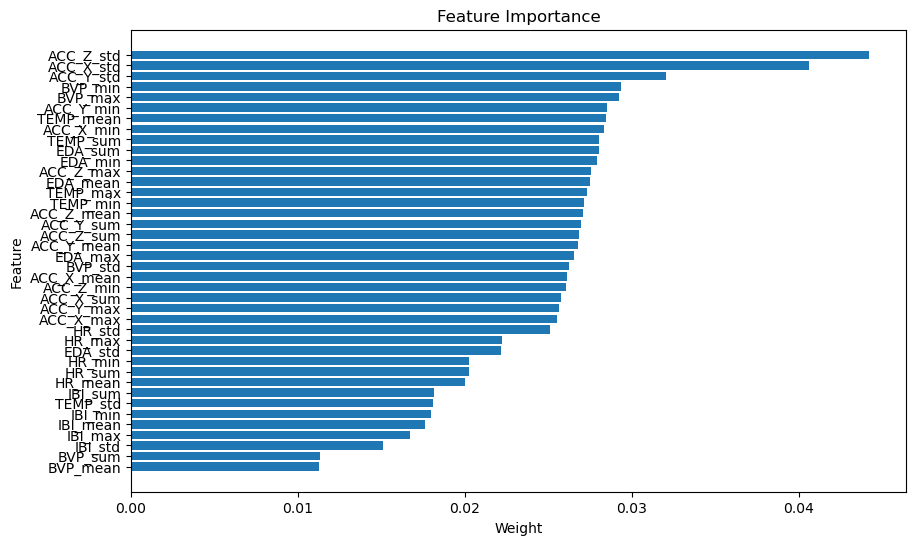

Weights (Coefficients) sorted:
ACC_Z_std: 0.04419318745579755
ACC_X_std: 0.040625504456004394
ACC_Y_std: 0.03203616775686305
BVP_min: 0.02933255876517625
BVP_max: 0.029231660727500355
ACC_Y_min: 0.02849667451276659
TEMP_mean: 0.028465836263657344
ACC_X_min: 0.028353683725311708
TEMP_sum: 0.028054660735261118
EDA_sum: 0.028050528661875768
EDA_min: 0.027912411581310522
ACC_Z_max: 0.027554571859756422
EDA_mean: 0.027495478763654144
TEMP_max: 0.02728145274034699
TEMP_min: 0.02714538508869614
ACC_Z_mean: 0.027045879174230313
ACC_Y_sum: 0.026965686681677026
ACC_Z_sum: 0.026827292100571064
ACC_Y_mean: 0.02677360469266973
EDA_max: 0.026552915057918305
BVP_std: 0.026249352215288232
ACC_X_mean: 0.02613287162390031
ACC_Z_min: 0.02602898232558585
ACC_X_sum: 0.025774424070151136
ACC_Y_max: 0.025627821220311042
ACC_X_max: 0.025485915323337688
HR_std: 0.025117603789016868
HR_max: 0.022244910885167016
EDA_std: 0.022179402838739048
HR_min: 0.020259550347966254
HR_sum: 0.020219503163881387
HR_mean: 0.01

In [41]:

sorted_features_weights = sorted(zip(X.columns, weights), key=lambda x: x[1], reverse=True)

sorted_features, sorted_weights = zip(*sorted_features_weights)

plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_weights)
plt.xlabel('Weight')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  
plt.show()

# แสดงผลเป็นตัวเลข
print("Weights (Coefficients) sorted:")
for feature, weight in sorted_features_weights:
    print(f"{feature}: {weight}")


========================================================================================================

ลองทำ auto

In [ ]:
from autogluon.tabular import TabularDataset, TabularPredictor
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [ ]:
df_train = pd.read_csv('summary_stats.csv')
df_test = pd.read_csv('summary_stats_test.csv')

In [ ]:
df_N = df_train[df_train['label'] == 'N']
df_W = df_train[df_train['label'] == 'W']
df_R = df_train[df_train['label'] == 'R']

# Oversample df_R ให้มี 8000 ตัวอย่าง
df_R_upsampled = df_R.sample(n=6996, random_state=42)

# ทำให้ N และ W มีขนาดเท่ากัน
df_N_undersampled = df_N.sample(n=15000, random_state=42)
df_W_undersampled = df_W.sample(n=7500, random_state=42)

# รวมข้อมูลให้สมดุล
df_balanced = pd.concat([df_N_undersampled, df_W_undersampled, df_R_upsampled], ignore_index=True)

# สุ่มเรียงใหม่
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
train_data, test_data = train_test_split(df_balanced, test_size=0.2, random_state=42)

In [ ]:
predictor = TabularPredictor(label='label', eval_metric='f1_macro').fit(
    train_data,
    presets='best_quality',  
    auto_stack=True,
    verbosity=2, 
    time_limit=3600,
)

In [ ]:
y_pred = predictor.predict(test_data.drop(columns=['label']))

In [ ]:
predictor.evaluate(test_data)

- 'f1_macro': 0.880170993448074,
- 'accuracy': 0.8788888888888889,
- 'balanced_accuracy': 0.8812047560964728,
- 'mcc': 0.8181994249276863

In [ ]:
predictor.leaderboard(test_data)

In [ ]:
y_pred = predictor.predict(df_test)

In [ ]:
Submission = pd.read_csv('sample_submission.csv')

In [ ]:
Submission["labels"] = y_pred

In [ ]:
Submission.to_csv('my_submission.csv', index=False)

====================================================================

| Model                      | Score Range |
|----------------------------|------------|
| **Deep Learning (DL)**      | 0.4701 - 0.54 |
| **Machine Learning (RF)**   | 0.57 - 0.58 |
| **Machine Learning (XGB)**  | 0.55 - 0.57 |
| **ML (RF-Best_Params_rf)**  | 0.5944 - 0.60694 | 
| **autogluon (best_quality)**  | 0.56 - 0.58384 | 

#ML (RF-Best_Params_rf) น่าจะผ่าน

📌 **Dataset Configuration**:  
- **R** = 6996  
- **N** = 15000  
- **W** = 7500  
